In [ ]:
#https://thinkinfi.com/fasttext-for-text-classification-python/

In [1]:
! pip install fasttext
import fasttext
import pandas as pd


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import KFold
import warnings
import matplotlib.pyplot as plt
import string


from nltk.stem import PorterStemmer
warnings.filterwarnings('ignore')

!pip install nltk
import nltk
nltk.download('all')
nltk.download('stopwords')
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree


from google.colab import files
uploaded1 = files.upload()
uploaded2 = files.upload()
uploaded3 = files.upload()
uploaded4 = files.upload()
import io


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393390 sha256=47014fac7559aea03c11c1451fd14b45733f98b6c922cb97db2227bd36675491
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

Saving X_train.csv to X_train.csv


Saving X_test.csv to X_test.csv


Saving y_train.csv to y_train.csv


Saving y_test.csv to y_test.csv


In [3]:
xtrain = pd.read_csv(io.BytesIO(uploaded1['X_train.csv']))
xtest =  pd.read_csv(io.BytesIO(uploaded2['X_test.csv']))
ytrain = pd.read_csv(io.BytesIO(uploaded3['y_train.csv']))
ytest =  pd.read_csv(io.BytesIO(uploaded4['y_test.csv']))

train_data = xtrain.merge(ytrain,on=["Unnamed: 0"])
test_data = xtest.merge(ytest,on=["Unnamed: 0"])
#train.head()
train_data.info(),test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4447 entries, 0 to 4446
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    4447 non-null   int64 
 1   first_party   4447 non-null   object
 2   second_party  4447 non-null   object
 3   Facts         4447 non-null   object
 4   winner_index  4447 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 208.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 791 entries, 0 to 790
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    791 non-null    int64 
 1   first_party   791 non-null    object
 2   second_party  791 non-null    object
 3   Facts         791 non-null    object
 4   winner_index  791 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 37.1+ KB


(None, None)

In [4]:
def K_fold (train_data1):
    n=4
    data = []
    
    kf = KFold(n_splits=n, random_state=42, shuffle=True)
    
    for train_index, val_index in kf.split(train_data1):
        train_df = train_data1.iloc[train_index]
        val_df = train_data1.iloc[val_index]
        data.append([train_df,val_df])
        
    return data

In [5]:
data = K_fold (train_data)

#print(train_data.info())

In [6]:
def prepare_data(train,val):
    # Write the train data to file
    with open("train_data.txt", "w", encoding="utf-8") as f:
        for i in range(len(train)):
            f.write("__label__" + str(train.iloc[i]["winner_index"]) + " " + train.iloc[i]["Facts"] + "\n")
            
    # Write the validation data to file
    with open("val_data.txt", "w", encoding="utf-8") as f:
        for i in range(len(val)):
            f.write("__label__" + str(val.iloc[i]["winner_index"]) + " " + val.iloc[i]["Facts"] + "\n")

In [7]:
def train_model():
    model = fasttext.train_supervised(input="train_data.txt", epoch=20, lr=1.0, wordNgrams=5, dim=300, loss="ns")

    result = model.test("train_data.txt")
    print("train-Accuracy:",result[1])
    
    result = model.test("val_data.txt")
    print("val-Accuracy:",result[1])
    
    return model

In [8]:
def predict(model):
    # predict the test data
    ypred = test_data["Facts"].apply(lambda x: model.predict(x)[0][0])
    ypred = [eval(x.replace('__label__', '')) for x in ypred]
    
    # Compute the accuracy
    accuracy = int(round(accuracy_score(test_data["winner_index"], ypred)*100))
    
    # Create the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix(test_data["winner_index"], ypred))
    disp.plot()
    plt.show()
    
    report = classification_report(test_data["winner_index"],ypred)
    print(report)

    return accuracy

train-Accuracy: 0.7070464767616191
val-Accuracy: 0.33093525179856115


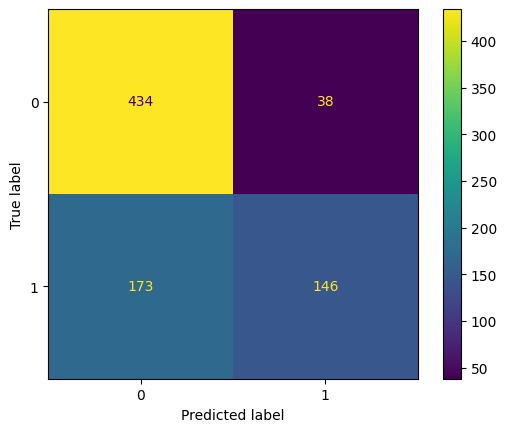

              precision    recall  f1-score   support

           0       0.71      0.92      0.80       472
           1       0.79      0.46      0.58       319

    accuracy                           0.73       791
   macro avg       0.75      0.69      0.69       791
weighted avg       0.75      0.73      0.71       791

train-Accuracy: 0.7073463268365817
val-Accuracy: 0.3327338129496403


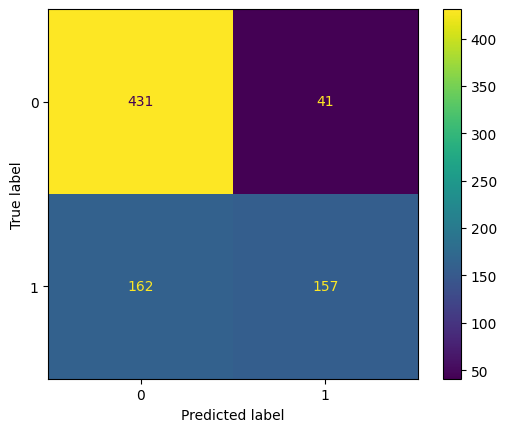

              precision    recall  f1-score   support

           0       0.73      0.91      0.81       472
           1       0.79      0.49      0.61       319

    accuracy                           0.74       791
   macro avg       0.76      0.70      0.71       791
weighted avg       0.75      0.74      0.73       791

train-Accuracy: 0.7091454272863568
val-Accuracy: 0.33902877697841727


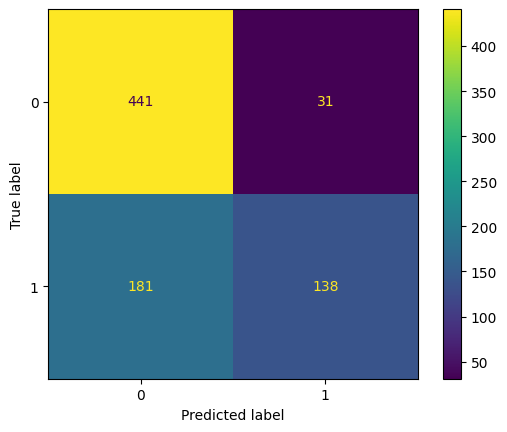

              precision    recall  f1-score   support

           0       0.71      0.93      0.81       472
           1       0.82      0.43      0.57       319

    accuracy                           0.73       791
   macro avg       0.76      0.68      0.69       791
weighted avg       0.75      0.73      0.71       791

train-Accuracy: 0.7155275779376499
val-Accuracy: 0.3195319531953195


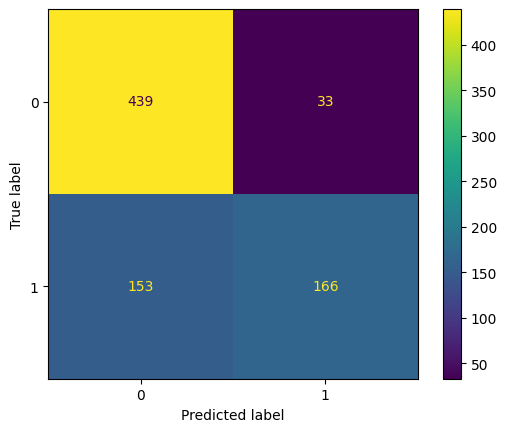

              precision    recall  f1-score   support

           0       0.74      0.93      0.83       472
           1       0.83      0.52      0.64       319

    accuracy                           0.76       791
   macro avg       0.79      0.73      0.73       791
weighted avg       0.78      0.76      0.75       791

average accuracy =  74 %


In [9]:
# No preprocessing-NO Balancing-No Anonymisation (1)
aver_acc = 0
for i in range(4):
    train = data[i][0]
    val = data[i][1]

    prepare_data(train, val)

    if i == 0:
        model1_1 = train_model()
        aver_acc = aver_acc + predict(model1_1)
    if i == 1:
        model1_2 = train_model()
        aver_acc = aver_acc + predict(model1_2)
    if i == 2:
        model1_3 = train_model()
        aver_acc = aver_acc + predict(model1_3)
    if i == 3:
        model1_4 = train_model()
        aver_acc = aver_acc + predict(model1_4)
        
print("average accuracy = ",round(aver_acc/4),"%")
    

In [ ]:
def Anonymisation(dff):

    for samplee in range(len(dff)):
        
        first_words = dff['first_party'].iloc[samplee].split()
        second_words = dff['second_party'].iloc[samplee].split()
        
        nltk_results = ne_chunk(pos_tag(word_tokenize(dff['Facts'].iloc[samplee])))
        
        for nltk_result in nltk_results:
            if type(nltk_result) == Tree:
                name = ''
                for nltk_result_leaf in nltk_result.leaves():
                    name += nltk_result_leaf[0] + ' '
            
                    #print ('Type: ', nltk_result.label(), 'Name: ', name)
                    if nltk_result.label() != 'PERSON':
                        dff['Facts'].iloc[samplee]=dff['Facts'].iloc[samplee].replace(name,'anonymized')
                
        dff['Facts'].iloc[samplee] = dff['Facts'].iloc[samplee].replace(dff['first_party'].iloc[samplee],'first_party') 
        dff['Facts'].iloc[samplee] = dff['Facts'].iloc[samplee].replace(dff['second_party'].iloc[samplee], 'second_party')

        for f_w in first_words:
            dff['Facts'].iloc[samplee] = dff['Facts'].iloc[samplee].replace(f_w , 'first_party')
        for s_w in second_words :
            dff['Facts'].iloc[samplee] = dff['Facts'].iloc[samplee].replace(s_w , 'second_party')
            
    return dff

train-Accuracy: 0.7109445277361319
val-Accuracy: 0.3183453237410072


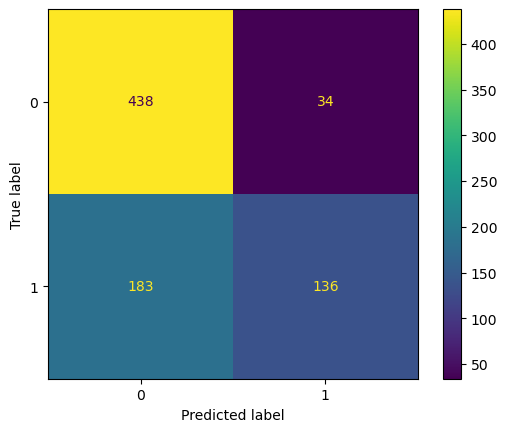

              precision    recall  f1-score   support

           0       0.71      0.93      0.80       472
           1       0.80      0.43      0.56       319

    accuracy                           0.73       791
   macro avg       0.75      0.68      0.68       791
weighted avg       0.74      0.73      0.70       791

train-Accuracy: 0.7106446776611695
val-Accuracy: 0.32643884892086333


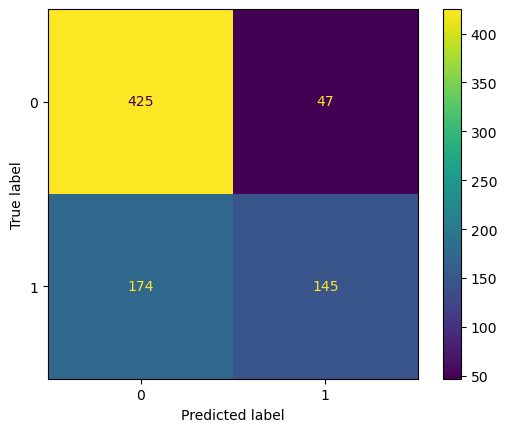

              precision    recall  f1-score   support

           0       0.71      0.90      0.79       472
           1       0.76      0.45      0.57       319

    accuracy                           0.72       791
   macro avg       0.73      0.68      0.68       791
weighted avg       0.73      0.72      0.70       791

train-Accuracy: 0.7112443778110945
val-Accuracy: 0.335431654676259


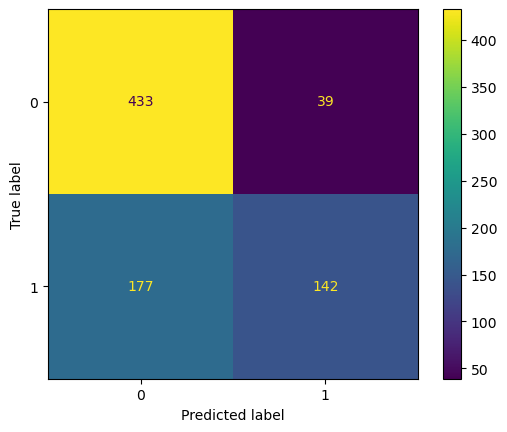

              precision    recall  f1-score   support

           0       0.71      0.92      0.80       472
           1       0.78      0.45      0.57       319

    accuracy                           0.73       791
   macro avg       0.75      0.68      0.68       791
weighted avg       0.74      0.73      0.71       791

train-Accuracy: 0.7170263788968825
val-Accuracy: 0.3195319531953195


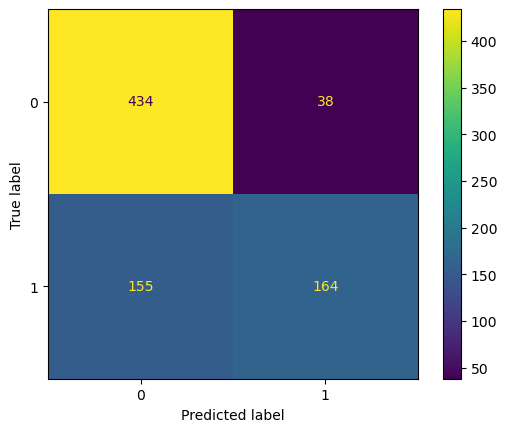

              precision    recall  f1-score   support

           0       0.74      0.92      0.82       472
           1       0.81      0.51      0.63       319

    accuracy                           0.76       791
   macro avg       0.77      0.72      0.72       791
weighted avg       0.77      0.76      0.74       791

average accuracy =  74 %


In [ ]:
# No preprocessing-NO Balancing- Anonymisation (2)
aver_acc = 0
for i in range(4):
    train = data[i][0]
    val = data[i][1]

    train = Anonymisation(train)
    val = Anonymisation(val)

    prepare_data(train, val)

    if i == 0:
        model2_1 = train_model()
        aver_acc = aver_acc + predict(model2_1)
    if i == 1:
        model2_2 = train_model()
        aver_acc = aver_acc + predict(model2_2)
    if i == 2:
        model2_3 = train_model()
        aver_acc = aver_acc + predict(model2_3)
    if i == 3:
        model2_4 = train_model()
        aver_acc = aver_acc + predict(model2_4)
        
print("average accuracy = ",round(aver_acc/4),"%")

In [ ]:
def Balancing(df):
    s = df['winner_index'].value_counts().max() - df['winner_index'].value_counts().min()
    df = df.drop(df.loc[df['winner_index'] == 0].sample(n=s).index)
    
    return df

In [ ]:
#print(train_data.info())
new_train = train_data
balanced_data = K_fold(Balancing(new_train))
#train_data.info()

train-Accuracy: 0.7431352102884949
val-Accuracy: 0.3524504692387904


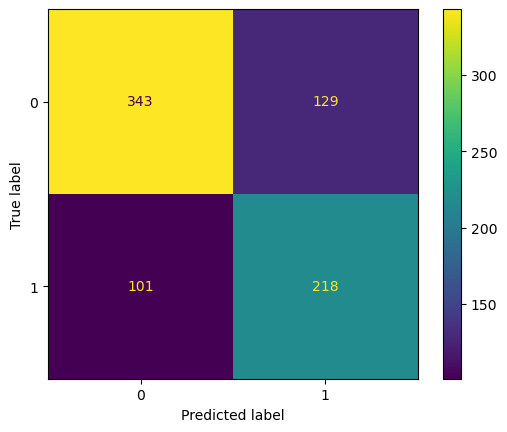

              precision    recall  f1-score   support

           0       0.77      0.73      0.75       472
           1       0.63      0.68      0.65       319

    accuracy                           0.71       791
   macro avg       0.70      0.71      0.70       791
weighted avg       0.71      0.71      0.71       791

train-Accuracy: 0.7358359402155022
val-Accuracy: 0.3660062565172054


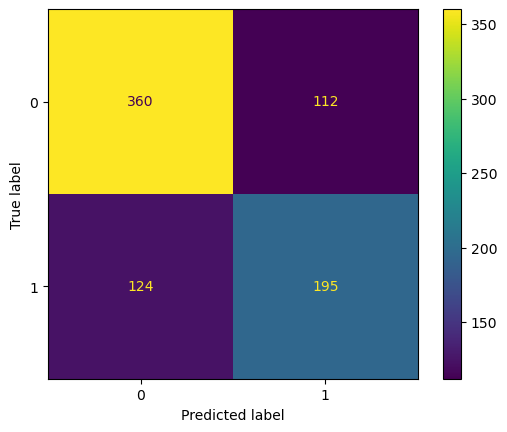

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       472
           1       0.64      0.61      0.62       319

    accuracy                           0.70       791
   macro avg       0.69      0.69      0.69       791
weighted avg       0.70      0.70      0.70       791

train-Accuracy: 0.7483489746263469
val-Accuracy: 0.34410844629822734


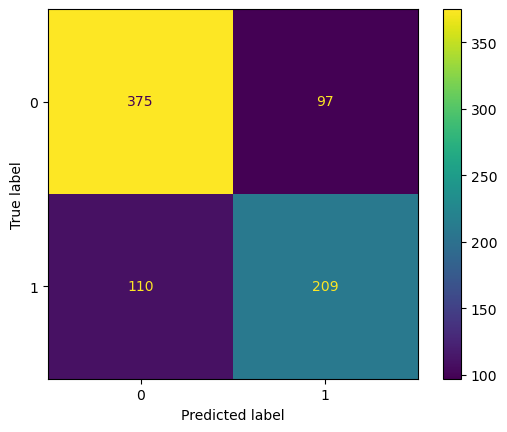

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       472
           1       0.68      0.66      0.67       319

    accuracy                           0.74       791
   macro avg       0.73      0.72      0.73       791
weighted avg       0.74      0.74      0.74       791

train-Accuracy: 0.7493917274939172
val-Accuracy: 0.32429614181439


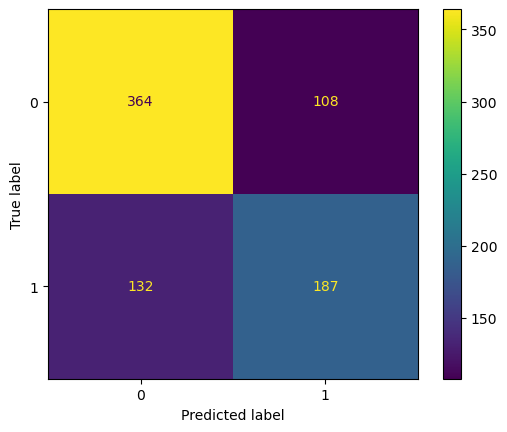

              precision    recall  f1-score   support

           0       0.73      0.77      0.75       472
           1       0.63      0.59      0.61       319

    accuracy                           0.70       791
   macro avg       0.68      0.68      0.68       791
weighted avg       0.69      0.70      0.69       791

average accuracy =  71 %


In [ ]:
# No preprocessing- Balancing - No Anonymisation (3)
aver_acc = 0
for i in range(4):
    train = balanced_data[i][0]
    val = balanced_data[i][1]

    prepare_data(train, val)

    if i == 0:
        model3_1 = train_model()
        aver_acc = aver_acc + predict(model3_1)
    if i == 1:
        model3_2 = train_model()
        aver_acc = aver_acc + predict(model3_2)
    if i == 2:
        model3_3 = train_model()
        aver_acc = aver_acc + predict(model3_3)
    if i == 3:
        model3_4 = train_model()
        aver_acc = aver_acc + predict(model3_4)
        
print("average accuracy = ",round(aver_acc/4),"%")

train-Accuracy: 0.7441779631560653
val-Accuracy: 0.3461939520333681


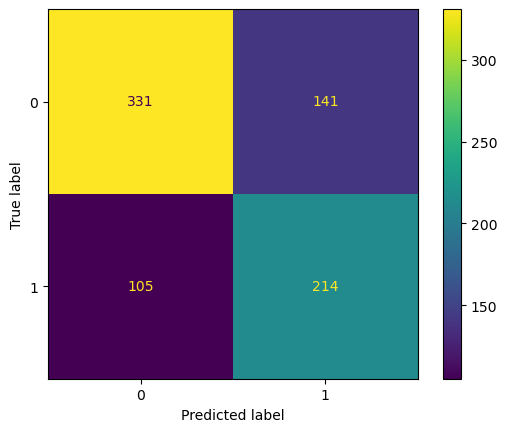

              precision    recall  f1-score   support

           0       0.76      0.70      0.73       472
           1       0.60      0.67      0.64       319

    accuracy                           0.69       791
   macro avg       0.68      0.69      0.68       791
weighted avg       0.70      0.69      0.69       791

train-Accuracy: 0.7372262773722628
val-Accuracy: 0.35766423357664234


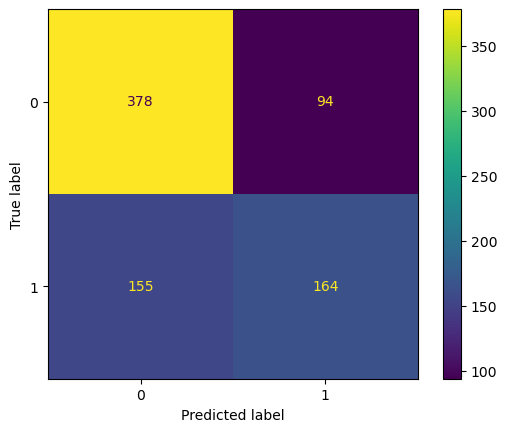

              precision    recall  f1-score   support

           0       0.71      0.80      0.75       472
           1       0.64      0.51      0.57       319

    accuracy                           0.69       791
   macro avg       0.67      0.66      0.66       791
weighted avg       0.68      0.69      0.68       791

train-Accuracy: 0.748696558915537
val-Accuracy: 0.3347236704900938


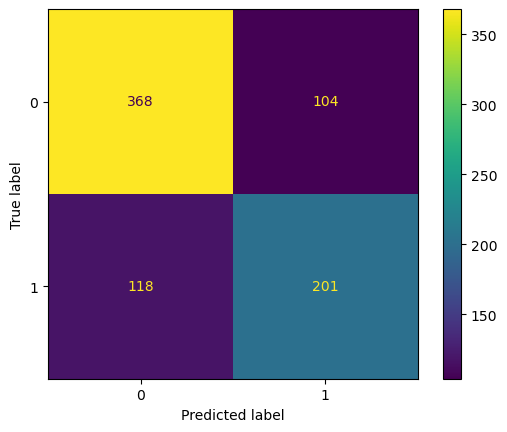

              precision    recall  f1-score   support

           0       0.76      0.78      0.77       472
           1       0.66      0.63      0.64       319

    accuracy                           0.72       791
   macro avg       0.71      0.70      0.71       791
weighted avg       0.72      0.72      0.72       791

train-Accuracy: 0.7511296489398679
val-Accuracy: 0.32116788321167883


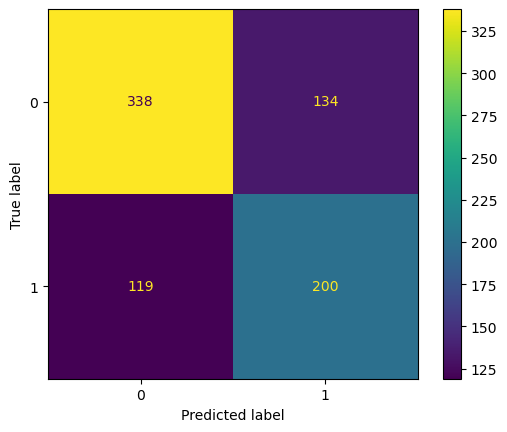

              precision    recall  f1-score   support

           0       0.74      0.72      0.73       472
           1       0.60      0.63      0.61       319

    accuracy                           0.68       791
   macro avg       0.67      0.67      0.67       791
weighted avg       0.68      0.68      0.68       791

average accuracy =  70 %


In [ ]:
# No preprocessing- Balancing -  Anonymisation (4)
aver_acc = 0
for i in range(4):
    train = balanced_data[i][0]
    val = balanced_data[i][1]

    train = Anonymisation(train)
    val = Anonymisation(val)

    prepare_data(train, val)

    if i == 0:
        model4_1 = train_model()
        aver_acc = aver_acc + predict(model4_1)
    if i == 1:
        model4_2 = train_model()
        aver_acc = aver_acc + predict(model4_2)
    if i == 2:
        model4_3 = train_model()
        aver_acc = aver_acc + predict(model4_3)
    if i == 3:
        model4_4 = train_model()
        aver_acc = aver_acc + predict(model4_4)
        
print("average accuracy = ",round(aver_acc/4),"%")

In [ ]:
def preprocessing(dff):
    processed_data = []
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    
    for df in dff:
        # Convert all strings to lowercase
        df = df.lower()
        
        # Remove punctuation
        df = df.translate(str.maketrans("", "", string.punctuation))
        
        # Tokenization
        words = word_tokenize(df)
        
        # Remove stop words and perform stemming
        words = [stemmer.stem(word) for word in words if word not in stop_words]
        
        # Append preprocessed string to list
        df = ' '.join(words)
        processed_data.append(df)
    
    return processed_data
    

3335 1112
train-Accuracy: 0.7124437781109445
val-Accuracy: 0.31564748201438847


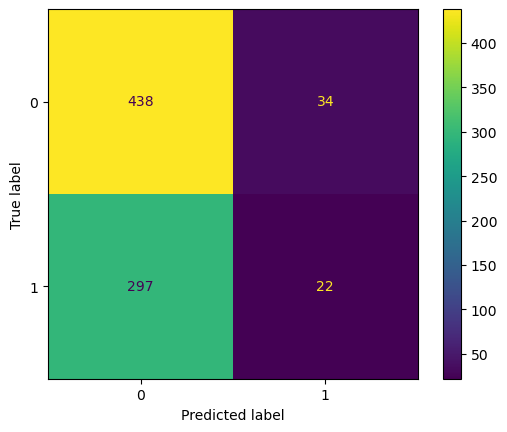

              precision    recall  f1-score   support

           0       0.60      0.93      0.73       472
           1       0.39      0.07      0.12       319

    accuracy                           0.58       791
   macro avg       0.49      0.50      0.42       791
weighted avg       0.51      0.58      0.48       791

3335 1112
train-Accuracy: 0.7133433283358321
val-Accuracy: 0.322841726618705


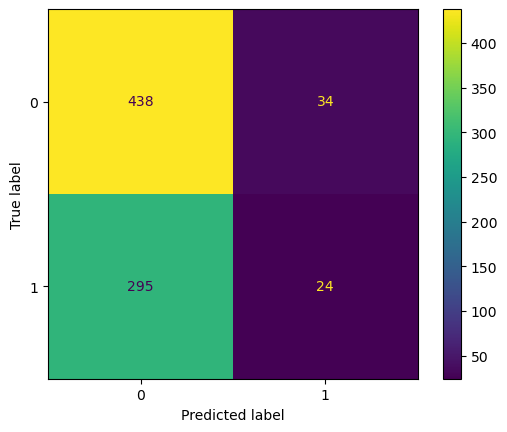

              precision    recall  f1-score   support

           0       0.60      0.93      0.73       472
           1       0.41      0.08      0.13       319

    accuracy                           0.58       791
   macro avg       0.51      0.50      0.43       791
weighted avg       0.52      0.58      0.49       791

3335 1112
train-Accuracy: 0.7151424287856072
val-Accuracy: 0.32194244604316546


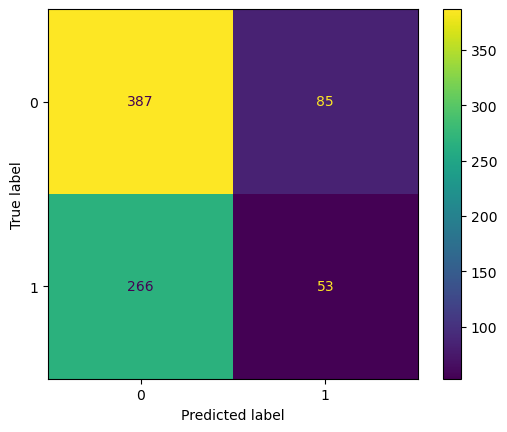

              precision    recall  f1-score   support

           0       0.59      0.82      0.69       472
           1       0.38      0.17      0.23       319

    accuracy                           0.56       791
   macro avg       0.49      0.49      0.46       791
weighted avg       0.51      0.56      0.50       791

3336 1111
train-Accuracy: 0.7176258992805755
val-Accuracy: 0.3114311431143114


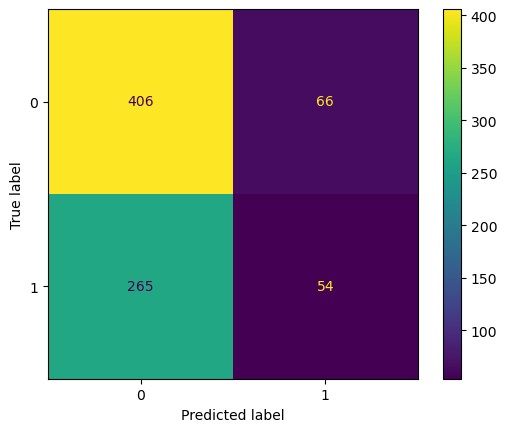

              precision    recall  f1-score   support

           0       0.61      0.86      0.71       472
           1       0.45      0.17      0.25       319

    accuracy                           0.58       791
   macro avg       0.53      0.51      0.48       791
weighted avg       0.54      0.58      0.52       791

average accuracy =  58 %


In [ ]:
#  preprocessing- No Balancing -  No Anonymisation (5)
aver_acc = 0
for i in range(4):
    train = data[i][0]
    val = data[i][1]

    train["Facts"] = preprocessing(train["Facts"])
    val["Facts"] = preprocessing(val["Facts"])
    
    prepare_data(train, val)

    if i == 0:
        model5_1 = train_model()
        aver_acc = aver_acc + predict(model5_1)
    if i == 1:
        model5_2 = train_model()
        aver_acc = aver_acc + predict(model5_2)
    if i == 2:
        model5_3 = train_model()
        aver_acc = aver_acc + predict(model5_3)
    if i == 3:
        model5_4 = train_model()
        aver_acc = aver_acc + predict(model5_4)
        
print("average accuracy = ",round(aver_acc/4),"%")

train-Accuracy: 0.7127436281859071
val-Accuracy: 0.31564748201438847


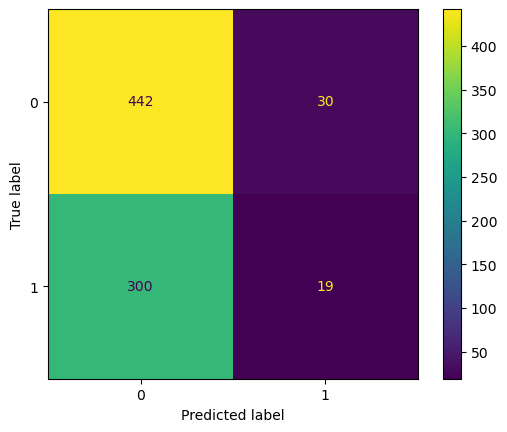

              precision    recall  f1-score   support

           0       0.60      0.94      0.73       472
           1       0.39      0.06      0.10       319

    accuracy                           0.58       791
   macro avg       0.49      0.50      0.42       791
weighted avg       0.51      0.58      0.48       791

train-Accuracy: 0.7133433283358321
val-Accuracy: 0.32194244604316546


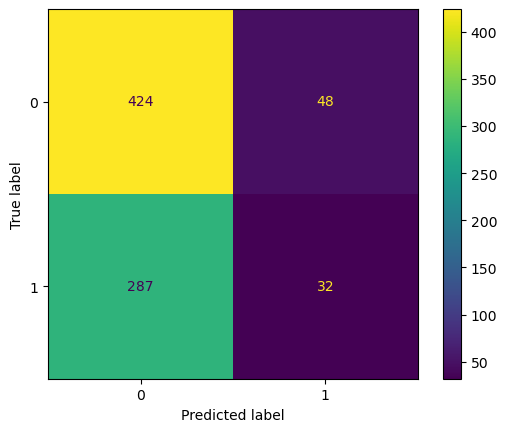

              precision    recall  f1-score   support

           0       0.60      0.90      0.72       472
           1       0.40      0.10      0.16       319

    accuracy                           0.58       791
   macro avg       0.50      0.50      0.44       791
weighted avg       0.52      0.58      0.49       791

train-Accuracy: 0.7154422788605698
val-Accuracy: 0.322841726618705


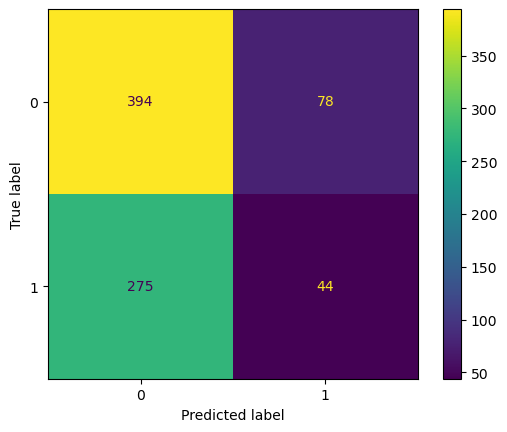

              precision    recall  f1-score   support

           0       0.59      0.83      0.69       472
           1       0.36      0.14      0.20       319

    accuracy                           0.55       791
   macro avg       0.47      0.49      0.45       791
weighted avg       0.50      0.55      0.49       791

train-Accuracy: 0.7176258992805755
val-Accuracy: 0.3096309630963096


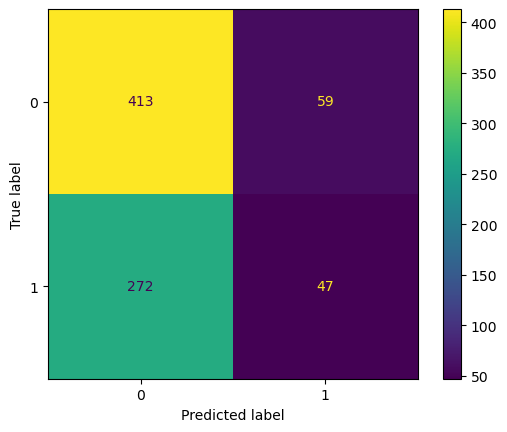

              precision    recall  f1-score   support

           0       0.60      0.88      0.71       472
           1       0.44      0.15      0.22       319

    accuracy                           0.58       791
   macro avg       0.52      0.51      0.47       791
weighted avg       0.54      0.58      0.52       791

average accuracy =  57 %


In [ ]:
#  preprocessing- No Balancing -   Anonymisation (6)
aver_acc = 0
for i in range(4):
    train = data[i][0]
    val = data[i][1]

    train["Facts"] = preprocessing(train["Facts"])
    val["Facts"] = preprocessing(val["Facts"])
    
    train = Anonymisation(train)
    val = Anonymisation(val)
    
    prepare_data(train, val)

    if i == 0:
        model6_1 = train_model()
        aver_acc = aver_acc + predict(model6_1)
    if i == 1:
        model6_2 = train_model()
        aver_acc = aver_acc + predict(model6_2)
    if i == 2:
        model6_3 = train_model()
        aver_acc = aver_acc + predict(model6_3)
    if i == 3:
        model6_4 = train_model()
        aver_acc = aver_acc + predict(model6_4)
        
print("average accuracy = ",round(aver_acc/4),"%")

train-Accuracy: 0.7455683003128258
val-Accuracy: 0.34306569343065696


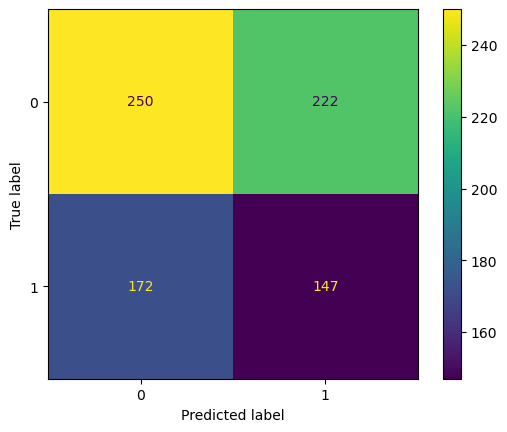

              precision    recall  f1-score   support

           0       0.59      0.53      0.56       472
           1       0.40      0.46      0.43       319

    accuracy                           0.50       791
   macro avg       0.50      0.50      0.49       791
weighted avg       0.51      0.50      0.51       791

train-Accuracy: 0.737921445950643
val-Accuracy: 0.3524504692387904


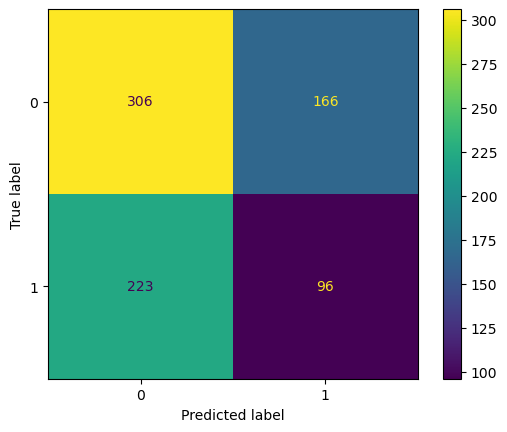

              precision    recall  f1-score   support

           0       0.58      0.65      0.61       472
           1       0.37      0.30      0.33       319

    accuracy                           0.51       791
   macro avg       0.47      0.47      0.47       791
weighted avg       0.49      0.51      0.50       791

train-Accuracy: 0.7504344803614876
val-Accuracy: 0.3232533889468196


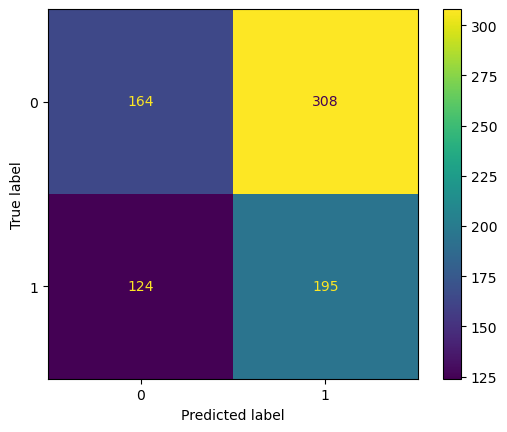

              precision    recall  f1-score   support

           0       0.57      0.35      0.43       472
           1       0.39      0.61      0.47       319

    accuracy                           0.45       791
   macro avg       0.48      0.48      0.45       791
weighted avg       0.50      0.45      0.45       791

train-Accuracy: 0.7518248175182481
val-Accuracy: 0.3149113660062565


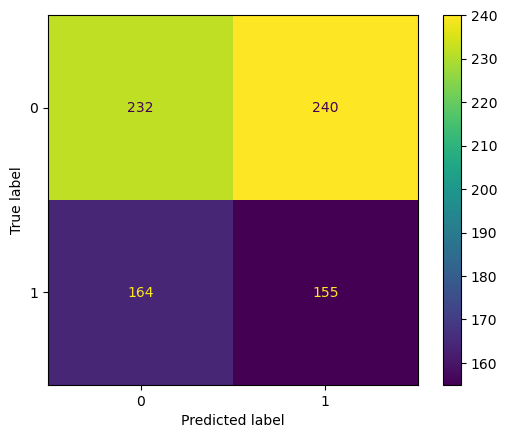

              precision    recall  f1-score   support

           0       0.59      0.49      0.53       472
           1       0.39      0.49      0.43       319

    accuracy                           0.49       791
   macro avg       0.49      0.49      0.48       791
weighted avg       0.51      0.49      0.49       791

average accuracy =  49 %


In [ ]:
#  preprocessing-  Balancing -   No Anonymisation (7)
aver_acc = 0
for i in range(4):
    train = balanced_data[i][0]
    val = balanced_data[i][1]
    
    train["Facts"] = preprocessing(train["Facts"])
    val["Facts"] = preprocessing(val["Facts"])

    prepare_data(train, val)

    if i == 0:
        model7_1 = train_model()
        aver_acc = aver_acc + predict(model7_1)
    if i == 1:
        model7_2 = train_model()
        aver_acc = aver_acc + predict(model7_2)
    if i == 2:
        model7_3 = train_model()
        aver_acc = aver_acc + predict(model7_3)
    if i == 3:
        model7_4 = train_model()
        aver_acc = aver_acc + predict(model7_4)

print("average accuracy = ",round(aver_acc/4),"%")

train-Accuracy: 0.7455683003128258
val-Accuracy: 0.33889468196037537


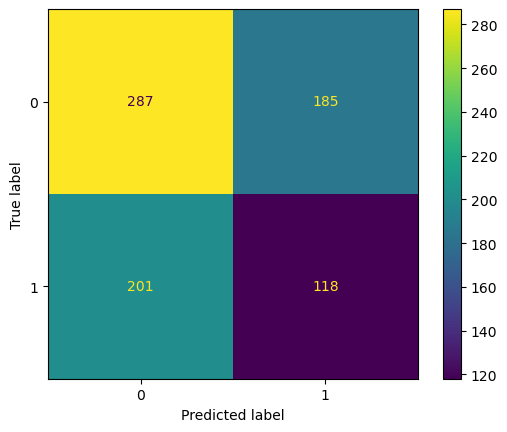

              precision    recall  f1-score   support

           0       0.59      0.61      0.60       472
           1       0.39      0.37      0.38       319

    accuracy                           0.51       791
   macro avg       0.49      0.49      0.49       791
weighted avg       0.51      0.51      0.51       791

train-Accuracy: 0.737921445950643
val-Accuracy: 0.3534932221063608


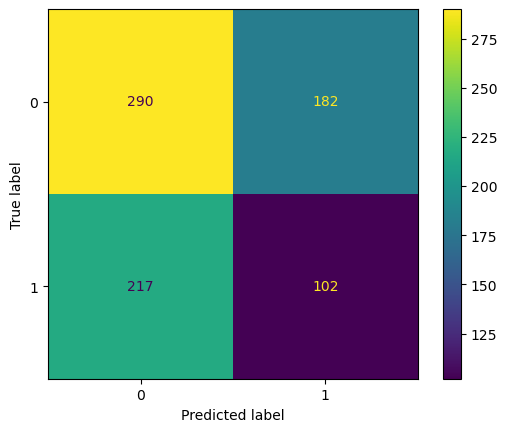

              precision    recall  f1-score   support

           0       0.57      0.61      0.59       472
           1       0.36      0.32      0.34       319

    accuracy                           0.50       791
   macro avg       0.47      0.47      0.47       791
weighted avg       0.49      0.50      0.49       791

train-Accuracy: 0.7500868960722975
val-Accuracy: 0.32533889468196037


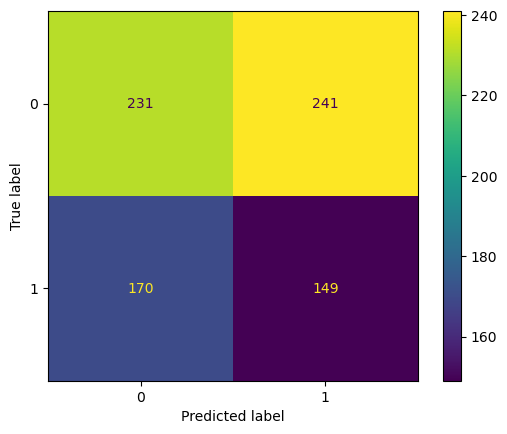

              precision    recall  f1-score   support

           0       0.58      0.49      0.53       472
           1       0.38      0.47      0.42       319

    accuracy                           0.48       791
   macro avg       0.48      0.48      0.47       791
weighted avg       0.50      0.48      0.49       791

train-Accuracy: 0.7518248175182481
val-Accuracy: 0.31386861313868614


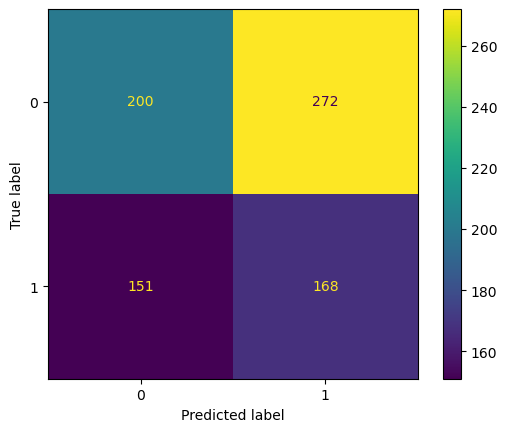

              precision    recall  f1-score   support

           0       0.57      0.42      0.49       472
           1       0.38      0.53      0.44       319

    accuracy                           0.47       791
   macro avg       0.48      0.48      0.46       791
weighted avg       0.49      0.47      0.47       791

average accuracy =  49 %


In [ ]:
#  preprocessing-  Balancing -    Anonymisation (8)
aver_acc = 0
for i in range(4):
    train = balanced_data[i][0]
    val = balanced_data[i][1]

    train["Facts"] = preprocessing(train["Facts"])
    val["Facts"] = preprocessing(val["Facts"])
    
    train = Anonymisation(train)
    val = Anonymisation(val)
    
    prepare_data(train, val)

    if i == 0:
        model8_1 = train_model()
        aver_acc = aver_acc + predict(model8_1)
    if i == 1:
        model8_2 = train_model()
        aver_acc = aver_acc + predict(model8_2)
    if i == 2:
        model8_3 = train_model()
        aver_acc = aver_acc + predict(model8_3)
    if i == 3:
        model8_4 = train_model()
        aver_acc = aver_acc + predict(model8_4)
        
print("average accuracy = ",round(aver_acc/4),"%")

In [10]:
# predict test_data 
yypred = test_data['Facts'].apply(lambda x : model1_4.predict(x)[0][0])
yypred = [eval(x.replace('__label__','')) for x in yypred]

accuracy = int(round(accuracy_score(test_data['winner_index'],yypred)*100))
accuracy

76

In [11]:
x=test_data['Facts'].iloc[50]
x

"Since the late 19th century, Texas sold land to facilitate settlement in the state and construction of schools. If, however, a purchaser missed an interest payment on the property, the land was immediately forfeited back to the state unless the owner made the payment before the land could be re-sold. Under this program, Greenbury Simmons purchased and then forfeited some land in 1947. Just over five years later he offered to pay the interest to re-acquire the property. The state refused to comply with his wishes citing a 1941 amendment to its law which gave individuals five years to claim their forfeited land. Simmons's land was sold to the City of El Paso in 1955."

In [12]:
labels = model1_4.predict(x)[0]
ypred = [eval(x.replace('__label__',''))for x in labels]

ypred

[0]

In [14]:
model1_4.save_model('best_fasttext.bin')